# final_analysis.py.ipynb
This notebook plots the figures for the manuscript. It starts with a single source of input data (`integrate_data.csv`). We restrict the analysis to our sample of interest (cells infected by a WT virus). Then, we plot the outcomes of infection.

Import Python modules:

In [31]:
from IPython.display import display
from dms_variants.constants import CBPALETTE
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as p9
from svgutils.compose import *

Set the theme for plots:

In [32]:
p9.theme_set(p9.theme_classic())

Set output folder for figures:

In [33]:
figure_dir = 'results/figures'
if not os.path.exists(figure_dir):
    # Create a new directory because it does not exist 
    os.makedirs(figure_dir)
    print(f"Made `{figure_dir}` directory ")
else:
    print(f"Directory `{figure_dir}` already exists.")

Directory `results/figures` already exists.


## Read integrated data
The general structure of the dataframe is that each cell barcode is listed on a row, and features of that cell are listed in columns. Cells that have more than one valid viral barcode identified may have multiple rows--one for each valid viral barcode.

In [34]:
integrated_data_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_integrate_data.csv'
integrated_data = pd.read_csv(integrated_data_csv)
integrated_data

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,barcoded_gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,freq_second_infection,freq_supernatant,max_freq_second_infection,max_freq_supernatant,contributes_progeny_second_infection,contributes_progeny_supernatant
0,AAACCCAGTAACAAGT,uninfected,none,47873,6,0.000125,0,2,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACCCATCATTGCTT,uninfected,none,90114,10,0.000111,1,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAACGAAAGATGTTGA,uninfected,none,111630,18,0.000161,0,3,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACGAAGTACTTCCC,infected,both,56828,24082,0.423770,7,2,13060,420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,8,319,1582,31,...,fluHA,AAGTAAGCGACATGAG,251.0,0.002019,0.000010,0.000076,0.000010,0.000076,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3678,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,1,0,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3679,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,8,93,1668,45,...,fluHA,AGTAAACTTCCTCGCG,65.0,0.000433,0.000010,0.000695,0.000028,0.001790,True,True
3680,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,8,93,1668,45,...,fluNA,ACATCTTATTTACACG,39.0,0.000260,0.000028,0.001790,0.000028,0.001790,True,True


### Process dataframe for analysis
Process the integrated dataframe so that each cell becomes a single row. Progeny contributions are summed for each cell, source, and barcoded gene (e.g. supernatant_freq_fluHA) and listed in a column.

In [35]:
min_viral_barcode_freq = 1e-5  # value assigned to unobserved viral barcodes

# aggregate observed viral barcodes for each gene and cell
processed_data = (
    integrated_data
    .groupby(["cell_barcode", "barcoded_gene"], as_index=False)
    .aggregate(
        n_viral_barcodes=pd.NamedAgg("viral_barcode", lambda v: v.astype(bool).astype(int).sum()),
        viral_barcodes=pd.NamedAgg("viral_barcode", "; ".join),
        freq_supernatant=pd.NamedAgg("freq_supernatant", "sum"),
        freq_second_infection=pd.NamedAgg("freq_second_infection", "sum"),
    )
)
assert processed_data.notnull().all().all()

# get barcoded viral genes
barcoded_genes = processed_data["barcoded_gene"].unique().tolist()

# now pivot so just one row per cell
pivoted_dfs = []
for col_to_pivot, fill_value in [
    ("n_viral_barcodes", 0),
    ("viral_barcodes", ""),
    ("freq_supernatant", pd.NA),
    ("freq_second_infection", pd.NA),
]:
    pivoted_dfs.append(
        processed_data
        .pivot_table(
            index="cell_barcode",
            columns="barcoded_gene",
            values=col_to_pivot,
            fill_value=fill_value,
            aggfunc='sum',
        )
        .rename_axis(None, axis=1)
        .rename(columns={gene: f"{col_to_pivot}_{gene}" for gene in barcoded_genes})
    )
assert all((pivoted_dfs[0].index == df.index).all() for df in pivoted_dfs)
processed_data = pd.concat(pivoted_dfs, axis=1).reset_index()

# now add back in cell-specific information
# Require infected cells since the above measurements only make sense for
# infected cells.
cell_info = (
    integrated_data
    [['cell_barcode', 'infected', 'infecting_viral_tag', 'total_UMIs',
       'viral_UMIs', 'frac_viral_UMIs', 'n_viral_genes'] +
     [c for c in integrated_data.columns
      if re.match("transcriptome_UMIs_flu|frac_UMIs_flu|present_flu|pacbio_UMIs|mutations_|mutation_support_", c)]
    ]
    .drop_duplicates()
)

assert set(processed_data["cell_barcode"]).issubset(cell_info["cell_barcode"])
processed_data = (
    cell_info.query('infected == "infected"')
    .merge(processed_data, on="cell_barcode", how="left", validate="one_to_one")
)

# add columns explaining missing genes
present_columns = {c: c.replace("present_flu", "") for c in processed_data.columns
                   if re.match("present_flu", c)}

processed_data = (
    processed_data
    .assign(
        all_viral_genes=lambda x: x['n_viral_genes'] == len(present_columns),
        missing_viral_genes=lambda x: x.apply(lambda row:
            "; ".join(val for (key, val) in present_columns.items() if not row[key]),
            axis=1)
    )
)

# check for complete pacbio data for all expressed viral genes
def virus_fully_sequenced(row):
    row_dict = row.to_dict()
    for key, val in row_dict.items():
        if re.fullmatch("present_flu\w+", key) and val:
            gene = key.split("_")[1]
            if row_dict[f"pacbio_UMIs_{gene}"] < 2:
                return False
    else:
        return True

processed_data = (
    processed_data
    .assign(virus_fully_sequenced=lambda x: x.apply(virus_fully_sequenced, axis=1))
)

# check to see if cell expresses both barcoded viral genes
processed_data["all_barcoded_genes"] = np.logical_and.reduce(
    [processed_data[f"present_{gene}"] for gene in barcoded_genes] +
    [processed_data[f"freq_supernatant_{gene}"].notnull() for gene in barcoded_genes] +
    [processed_data[f"freq_second_infection_{gene}"].notnull() for gene in barcoded_genes]
)

# annotate cells with both complete pacbio data and both barcoded viral genes
processed_data["sequenced_and_barcoded"] = np.logical_and(
    processed_data["virus_fully_sequenced"],
    processed_data["all_barcoded_genes"]
)

## Restrict analysis to WT infected cells
I only want to plot our sample of interest, which is made up of cells infected by a WT virus. Make a dataframe containing only these cells.

In [36]:
wt_infected_cells = (
    processed_data
    .query('infected == "infected" and infecting_viral_tag == "wt"'))
wt_infected_cells

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
1,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,8,319,1582,31,...,GTAGGCGATAAGTGGA,7.57407e-05,7.62399e-05,1e-05,1e-05,True,,False,True,False
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,CTCGTTTTCGGAGTAC; GACTATCTAATTGAGG,0.00353158,0.000134919,0.000164641,2e-05,False,PA,True,True,True
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,TTTACTTTAAGTGCTT,1e-05,1e-05,1e-05,1e-05,True,,True,True,True
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,AGTTATTGGTTGGATA,2e-05,0.000971284,2e-05,2.17873e-05,True,,True,True,True
7,AACTTCTGTGAGACGT,infected,wt,137078,2955,0.021557,8,100,845,8,...,GATAAGTATGACAAAG,1e-05,1e-05,1e-05,1e-05,True,,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,GAGCTCCTGTATTGCC,1e-05,1e-05,1e-05,1e-05,False,PA,True,True,True
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,TAAAAAATGTCTCATG,0.00101405,0.00128394,0.000153675,1.54824e-05,True,,True,True,True
407,TTTACCAGTCGCTTAA,infected,wt,114567,1434,0.012517,7,125,609,15,...,ATTTGGATGTAGGGGC; TTGGAGGAGACCCGTG,0.000106389,0.00122169,2e-05,2.8581e-05,False,PA,False,True,False
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,GGTATCAGTTATTGTT,1e-05,1e-05,1e-05,1e-05,False,NS; PB1,True,True,True


Quick summary of statistics about our dataset. I will use these numbers in later to check that figures contain the correct number of cells.

In [37]:
n_wt_infected_cells = wt_infected_cells["cell_barcode"].nunique()
print(f'There are {n_wt_infected_cells} cells in the dataset.')

There are 254 cells in the dataset.


## Plots of all wt infected cells
### Viral transcription

In [38]:
print(f'The maximum fraction of viral transcription '
      f'in an infected cells is {wt_infected_cells["frac_viral_UMIs"].max()}')

The maximum fraction of viral transcription in an infected cells is 0.6711695819913736


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3 x 1.25 in image.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/figures/viral_transcription.svg


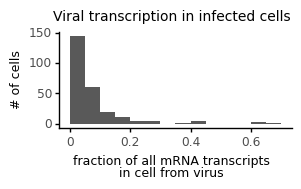

<ggplot: (8789011824276)>

In [39]:
viral_transcription_file = figure_dir+'/'+'viral_transcription.svg'

viral_transcription_plot = (
    p9.ggplot(
        wt_infected_cells[['cell_barcode','frac_viral_UMIs']].drop_duplicates(),
        p9.aes(x='frac_viral_UMIs')) +
    p9.geom_histogram(breaks=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,
                              0.4,0.45,0.5,0.55,0.6,0.65,0.7]) +
    p9.ggtitle(f'Viral transcription in infected cells') +
    p9.labs(x='fraction of all mRNA transcripts\nin cell from virus',
            y='# of cells') +
    p9.theme(figure_size=(3, 1.25),
             plot_title=p9.element_text(size=10),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center'))
viral_transcription_plot.save(filename = viral_transcription_file)
display(viral_transcription_plot)

### Viral genes per infected cell

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2 x 1 in image.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/figures/genes_per_cell.svg


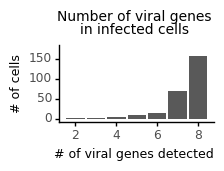

<ggplot: (8789018574282)>

In [40]:
genes_per_cell_file = figure_dir+'/'+'genes_per_cell.svg'

genes_per_cell_plot = (
    p9.ggplot(
        wt_infected_cells[['cell_barcode', 'n_viral_genes']].drop_duplicates(),
        p9.aes(x='n_viral_genes')) +
    p9.geom_bar(stat='count', position='dodge') +
    p9.ggtitle('Number of viral genes\n'
               'in infected cells') +
    p9.labs(x='# of viral genes detected',
            y='# of cells') +
    p9.scale_y_continuous(limits=[0,175], breaks=[0,50,100,150]) +
    p9.theme(figure_size=(2, 1),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
genes_per_cell_plot.save(filename = genes_per_cell_file)
display(genes_per_cell_plot)

### Viral gene presence or absence

Make a new dataframe with cell barcode, frac_viral_UMIs, and gene as columns. For each cell, list whether the gene is present and the fraction of gene UMIs in the cell.

In [41]:
gene_present_by_cell = (
    wt_infected_cells
    [['cell_barcode',
      'present_fluPB2', 'present_fluPB1',
      'present_fluPA', 'present_fluHA',
      'present_fluNP', 'present_fluNA',
      'present_fluM', 'present_fluNS']]
    .drop_duplicates()
    .melt(
        id_vars=['cell_barcode'],
        var_name='gene',
        value_name='gene_present')
)
gene_present_by_cell['gene'] = (
    gene_present_by_cell['gene']
    .str.split('_').str[-1])

gene_frac_by_cell = (
    wt_infected_cells
    [['cell_barcode', 'frac_viral_UMIs',
      'frac_UMIs_fluPB2', 'frac_UMIs_fluPB1',
      'frac_UMIs_fluPA', 'frac_UMIs_fluHA',
      'frac_UMIs_fluNP', 'frac_UMIs_fluNA',
      'frac_UMIs_fluM', 'frac_UMIs_fluNS']]
    .drop_duplicates()
    .melt(
        id_vars=['cell_barcode', 'frac_viral_UMIs'],
        var_name='gene',
        value_name='frac_gene_UMIs')
)
gene_frac_by_cell['gene'] = (
    gene_frac_by_cell['gene']
    .str.split('_').str[-1])

viral_genes_by_cell = pd.merge(
    left=gene_present_by_cell,
    right=gene_frac_by_cell,
    on=['cell_barcode','gene'],
    how='outer'
)
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene']
    .replace(['fluPB2', 'fluPB1', 'fluPA', 'fluHA',
              'fluNP', 'fluNA', 'fluM', 'fluNS'],
             ['PB2', 'PB1', 'PA', 'HA',
              'NP', 'NA', 'M', 'NS']))
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene'].astype('category'))
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene']
    .cat.reorder_categories(
        ['PB2', 'PB1', 'PA', 'HA',
         'NP', 'NA', 'M', 'NS']))
viral_genes_by_cell['gene_present'] = (
    viral_genes_by_cell['gene_present']
    .replace([True,False],
             ["Gene present", "Gene absent"]))

assert((viral_genes_by_cell['cell_barcode'].unique() == \
        wt_infected_cells['cell_barcode'].unique()).all())

display(viral_genes_by_cell)

gene_absence_rate = pd.DataFrame(
    viral_genes_by_cell
    .groupby(['gene'])
    ['gene_present']
    .value_counts(normalize=True)
    .reset_index(name='fraction_cells'))


assert(gene_absence_rate['gene'].nunique() == 8)

display(gene_absence_rate)

,cell_barcode,gene,gene_present,frac_viral_UMIs,frac_gene_UMIs
0,AAACGAAGTAGACGTG,PB2,Gene present,0.037429,0.000024
1,AAAGGGCTCCGCACTT,PB2,Gene present,0.023505,0.009943
2,AAAGTCCAGTAGAGTT,PB2,Gene present,0.199591,0.003653
3,AACCAACAGGGTCTTT,PB2,Gene present,0.131641,0.001074
4,AACTTCTGTGAGACGT,PB2,Gene present,0.021557,0.000146
...,...,...,...,...,...
2027,TTGCGTCCACCCTCTA,NS,Gene present,0.011315,0.002885
2028,TTGGGATGTAACGATA,NS,Gene present,0.058569,0.022673
2029,TTTACCAGTCGCTTAA,NS,Gene present,0.012517,0.004836
2030,TTTCACAAGCCAAGCA,NS,Gene absent,0.033731,0.000015


,gene,gene_present,fraction_cells
0,PB2,Gene present,0.933071
1,PB2,Gene absent,0.066929
2,PB1,Gene present,0.960630
3,PB1,Gene absent,0.039370
4,PA,Gene present,0.913386
5,PA,Gene absent,0.086614
6,HA,Gene present,0.854331
7,HA,Gene absent,0.145669
8,NP,Gene present,0.960630
9,NP,Gene absent,0.039370


Plot the fraction of infected cells missing each viral gene.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3 x 1.5 in image.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/figures/gene_absence_plot.svg


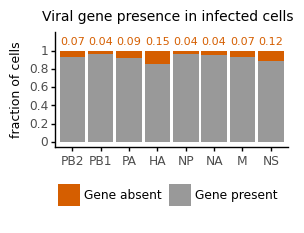

<ggplot: (8789011658590)>

In [42]:
gene_absence_file = figure_dir+'/'+'gene_absence_plot.svg'

gene_absence_plot = (
    p9.ggplot(gene_absence_rate,
              p9.aes(x='gene',
                     y='fraction_cells',
                     fill='gene_present')) +
    p9.geom_bar(stat='identity') +
    p9.geom_text(data=gene_absence_rate.query('gene_present == "Gene absent"'),
           mapping=p9.aes(x='gene',
                          y=1.1,
                          label='fraction_cells'),
                          format_string='{:.2f}',
                          size=8,
                          color=CBPALETTE[6]) +
    p9.ggtitle('Viral gene presence in infected cells') +
    p9.labs(x = '', y='fraction of cells') +
    p9.scale_y_continuous(limits=[0,1.15],
                          breaks=[0,0.2,0.4,0.6,0.8,1])+
    p9.theme(figure_size=(3, 1.5),
       plot_title=p9.element_text(size=10),
       axis_title=p9.element_text(size=9),
       legend_position='bottom',
       legend_box_spacing=0.2,
       legend_title=p9.element_blank()) +
    p9.scale_fill_manual([CBPALETTE[6],CBPALETTE[0]]))

gene_absence_plot.save(filename = gene_absence_file)
display(gene_absence_plot)

Make a composite figure showing viral transcription, number of viral genes per cell, and rate of viral gene absence.

In [43]:
fig2_file = figure_dir+'/'+'fig2.svg'

fig2 = (Figure("20cm", "16cm",
       Panel(
#            Grid(20, 20),
           SVG(viral_transcription_file),
           Text("A", 5, 15, size=14)).scale(2),
       Panel(
           SVG(genes_per_cell_file),
           Text("B", 5, 15, size=14)).scale(2).move(80,0),
       Panel(
           SVG(gene_absence_file),
           Text("C", 5, 15, size=14)).scale(2),
       )
 .tile(2,2))
display(fig2)
fig2.save(fig2_file)

Plot the expression of each viral gene relative to total viral expression.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6 x 3 in image.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/figures/gene_expression_plot.svg
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


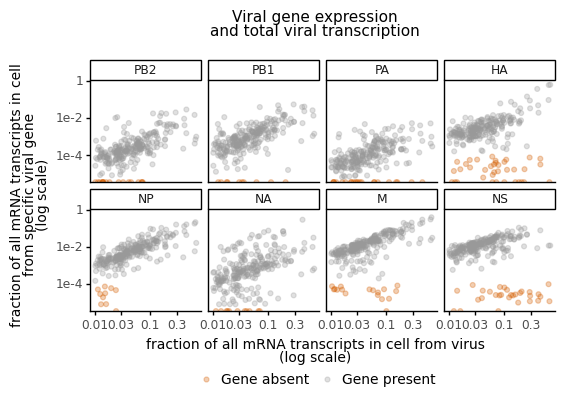

<ggplot: (8789011876627)>

In [44]:
gene_expression_file = figure_dir+'/'+'gene_expression_plot.svg'

gene_expression_plot = (
    p9.ggplot(viral_genes_by_cell,
               p9.aes(x='frac_viral_UMIs',
                      y='frac_gene_UMIs',
                      color='gene_present')) +
    p9.geom_point(alpha=0.3) +
    p9.facet_wrap('~gene', ncol=4) +
    p9.ggtitle(f'Viral gene expression\n'
               f'and total viral transcription\n') +
    p9.labs(x='fraction of all mRNA transcripts in cell from virus\n(log scale)',
            y='fraction of all mRNA transcripts in cell\nfrom specific viral gene\n(log scale)') +
    p9.scale_x_log10() +
    p9.scale_y_log10() +
    p9.theme(figure_size=(6, 3),
             plot_title=p9.element_text(size=11),
             axis_title=p9.element_text(size=10),
             legend_position='bottom',
             legend_box_spacing=0.4,
             legend_title=p9.element_blank(),
             legend_text=p9.element_text(size=10)) +
    p9.scale_color_manual([CBPALETTE[6],CBPALETTE[0]]))

gene_expression_plot.save(filename = gene_expression_file)
display(gene_expression_plot)

## Plots of fully-sequenced wt infected cells
I will further subset the cells for the following analyses. I will require the cells to have PacBio sequencing information for all expressed viral genes, so that we can call consensus genomes.


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2.5 x 1.5 in image.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/figures/fully_sequenced_plot.svg


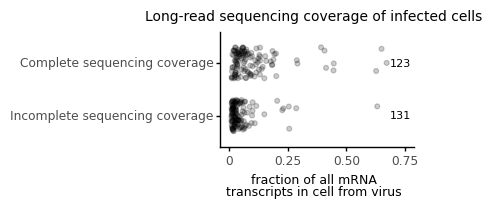

<ggplot: (8789012087971)>

In [45]:
fully_sequenced_file = figure_dir+'/'+'fully_sequenced_plot.svg'

fully_sequenced_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='virus_fully_sequenced',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.2, height=0, width=0.3) +
    p9.geom_text(data=wt_infected_cells.groupby('virus_fully_sequenced').nunique().reset_index(),
                 mapping=p9.aes(y=0.73,
                                label='cell_barcode'),
                 size=8) +
    p9.ggtitle(f'Long-read sequencing coverage of infected cells') +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction of all mRNA\ntranscripts in cell from virus') +
    p9.scale_y_continuous(limits=[0,0.75], breaks=[0,0.25,0.5,0.75]) +
    p9.scale_x_discrete(labels=['Incomplete sequencing coverage', 'Complete sequencing coverage']) +
    p9.theme(figure_size=(2.5, 1.5),
             plot_title=p9.element_text(size=10),
             axis_title=p9.element_text(size=9)))

fully_sequenced_plot.save(filename = fully_sequenced_file)
display(fully_sequenced_plot)

In [46]:
display(wt_infected_cells
        .groupby(["virus_fully_sequenced"])
        .aggregate(n_cells=pd.NamedAgg("cell_barcode", "count"))
)

fully_sequenced_cells = (
    wt_infected_cells
    .query('virus_fully_sequenced == True'))
display(fully_sequenced_cells)

,n_cells
virus_fully_sequenced,
False,131
True,123


,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,CTCGTTTTCGGAGTAC; GACTATCTAATTGAGG,0.00353158,0.000134919,0.000164641,2e-05,False,PA,True,True,True
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,TTTACTTTAAGTGCTT,1e-05,1e-05,1e-05,1e-05,True,,True,True,True
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,AGTTATTGGTTGGATA,2e-05,0.000971284,2e-05,2.17873e-05,True,,True,True,True
10,AAGGAATAGATTGAGT,infected,wt,51455,1667,0.032397,6,3,435,99,...,TCGGTGGATAACCTTG,<NA>,1e-05,<NA>,1e-05,False,HA; PB2,True,False,False
11,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,48,...,CTGTTGTTCTTTACCA,1e-05,7.18982e-05,0.000202201,0.000165321,True,,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,82,...,GTATTTGCAAAAAATG,0.000129506,0.000903955,1e-05,1.37795e-05,True,,True,True,True
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,GAGCTCCTGTATTGCC,1e-05,1e-05,1e-05,1e-05,False,PA,True,True,True
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,TAAAAAATGTCTCATG,0.00101405,0.00128394,0.000153675,1.54824e-05,True,,True,True,True
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,GGTATCAGTTATTGTT,1e-05,1e-05,1e-05,1e-05,False,NS; PB1,True,True,True


### Aggregate mutation information

In [47]:
def viral_mutations(row):
    row_dict = row.to_dict()
    mutations = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                mutations.append(f"{gene}: {val}")
    return ", ".join(mutations)

def nonsynonymous_mutations(row):
    row_dict = row.to_dict()
    nonsynonymous_mutations = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                for x in val.split(' '):
                    if "synonymous" in x:
                        pass
                    elif "noncoding" in x:
                        pass
                    else:
                        nonsynonymous_mutations.append(f"{gene}: {x}")
    return ", ".join(nonsynonymous_mutations)

def nonsynonymous_mutation_count(row):
    row_dict = row.to_dict()
    nonsynonymous_mutation_count = 0
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                for x in val.split(' '):
                    if "synonymous" in x:
                        pass
                    elif "noncoding" in x:
                        pass
                    else:
                        nonsynonymous_mutation_count += 1
    return nonsynonymous_mutation_count

def mutation_support(row):
    row_dict = row.to_dict()
    support_vals = []
    for key, val in row_dict.items():
        if re.fullmatch("mutation_support_flu\w+", key) and val:
            gene = key.replace("mutation_support_flu", "")
            if val != "Not Applicable":
                support_vals.append(f"{gene}: {val}")
    return ", ".join(support_vals)

def mutated_genes(row):
    row_dict = row.to_dict()
    mutated_genes = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                mutated_genes.append(gene)
    return ", ".join(mutated_genes)

fully_sequenced_cells = (
    fully_sequenced_cells
    .assign(
        viral_mutations=lambda x: x.apply(viral_mutations, axis=1),
        nonsynonymous_mutations=lambda x: x.apply(nonsynonymous_mutations, axis=1),
        mutation_support=lambda x: x.apply(mutation_support, axis=1),
        mutated_genes=lambda x: x.apply(mutated_genes, axis=1),
        has_mutations=lambda x: x["mutated_genes"].astype(bool),
        has_nonsynonymous_mutations=lambda x: x["nonsynonymous_mutations"].astype(bool),
        nonsynonymous_mutation_count=lambda x: x.apply(nonsynonymous_mutation_count, axis=1)
    )
)
display(fully_sequenced_cells)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded,viral_mutations,nonsynonymous_mutations,mutation_support,mutated_genes,has_mutations,has_nonsynonymous_mutations,nonsynonymous_mutation_count
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,True,True,True,PB2: del168to2007 del2097to2106,"PB2: del168to2007, PB2: del2097to2106",PB2: 1597/1611 1601/1611,PB2,True,True,2
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,True,True,True,,,,,False,False,0
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,True,True,True,"M: A111C_synonymous, NA: del39to1256, NS: G550...","NA: del39to1256, NS: G550A_G184R, PA: A937C_T313P","M: 436/472, NA: 1483/1550, NS: 48/50, PA: 7/9","M, NA, NS, PA",True,True,3
10,AAGGAATAGATTGAGT,infected,wt,51455,1667,0.032397,6,3,435,99,...,True,False,False,,,,,False,False,0
11,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,48,...,True,True,True,"NA: del43to43, PB2: T650A_F217Y","NA: del43to43, PB2: T650A_F217Y","NA: 14/14, PB2: 4/4","NA, PB2",True,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,82,...,True,True,True,,,,,False,False,0
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,True,True,True,HA: A954G_synonymous,,HA: 15/16,HA,True,False,0
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,True,True,True,,,,,False,False,0
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,True,True,True,HA: T465A_H155Q,HA: T465A_H155Q,HA: 85/90,HA,True,True,1


### PacBio statistics
Calculate how many infected cells we characterized, how many conensus viral sequences have mutations, and what kinds of mutations they carry.

In [48]:
mutated_cell_counts = (
    pd.DataFrame(
        fully_sequenced_cells.groupby(['all_viral_genes', 'has_nonsynonymous_mutations'])
        ['cell_barcode'].nunique()).reset_index()
    .rename(columns={'cell_barcode': 'n_cells'}))

def label_cells(row):
    cell_label = None
    if row['all_viral_genes'] == True:
        if row['has_nonsynonymous_mutations'] == False:
            cell_label = "Unmutated genome"
        else:
            cell_label = "Non-synonymous mutations"
    elif row['all_viral_genes'] == False:
        if row['has_nonsynonymous_mutations'] == False:
            cell_label = "Missing gene(s)"
        else:
            cell_label = "Non-synonymous mutations\nand missing gene(s)"
    return cell_label

mutated_cell_counts = (
    mutated_cell_counts
    .assign(
        cell_label=lambda x: x.apply(label_cells, axis=1).astype('category'))
)
mutated_cell_counts['cell_label'] = (
    mutated_cell_counts['cell_label']
    .cat.reorder_categories(
        ['Unmutated genome', 'Missing gene(s)',
         'Non-synonymous mutations', 'Non-synonymous mutations\nand missing gene(s)']))

display(mutated_cell_counts)

,all_viral_genes,has_nonsynonymous_mutations,n_cells,cell_label
0,False,False,33,Missing gene(s)
1,False,True,19,Non-synonymous mutations\nand missing gene(s)
2,True,False,41,Unmutated genome
3,True,True,30,Non-synonymous mutations


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2 x 1.5 in image.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/figures/mutated_cell_counts_plot.svg


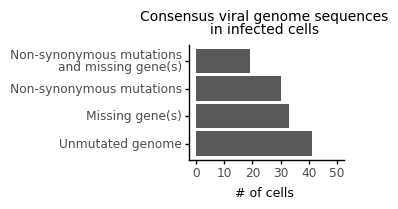

<ggplot: (8789011949526)>

In [49]:
mutated_cell_counts_file = figure_dir+'/'+'mutated_cell_counts_plot.svg'

mutated_cell_counts_plot = (
    p9.ggplot(mutated_cell_counts,
              p9.aes(x='cell_label',
                     y='n_cells')) +
    p9.geom_bar(stat='identity') +
    p9.coord_flip() +
    p9.ggtitle('Consensus viral genome sequences\nin infected cells') +
    p9.labs(x = '', y='# of cells') +
    p9.ylim([0,50]) +
    p9.theme(figure_size=(2, 1.5),
       plot_title=p9.element_text(size=10),
       axis_title=p9.element_text(size=9),
       legend_box_spacing=0.2,
       legend_title=p9.element_blank()))

mutated_cell_counts_plot.save(filename = mutated_cell_counts_file)
display(mutated_cell_counts_plot)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2 x 1.4 in image.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/figures/mutations_per_cell.svg


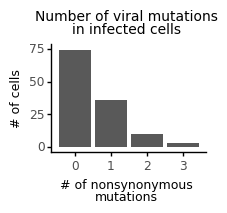

<ggplot: (8789012035681)>

In [50]:
mutations_per_cell_file = figure_dir+'/'+'mutations_per_cell.svg'

mutations_per_cell_plot = (
    p9.ggplot(
        fully_sequenced_cells,
        p9.aes(x='nonsynonymous_mutation_count')) +
    p9.geom_bar() +
    p9.ggtitle(f'Number of viral mutations\nin infected cells') +
    p9.labs(x='# of nonsynonymous\nmutations',
            y='# of cells') +
    p9.scale_y_continuous(limits=[0,75], breaks=[0,25,50,75]) +
    p9.theme(figure_size=(2, 1.4),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
mutations_per_cell_plot.save(filename = mutations_per_cell_file)
display(mutations_per_cell_plot)

Make a composite figure showing viral genotypes and number of mutations per genome.

In [51]:
fig3_file = figure_dir+'/'+'fig3.svg'

fig3 = (Figure("20cm", "6cm",
       Panel(
#           Grid(20, 20),
           SVG(mutated_cell_counts_file),
           Text("A", 5, 15, size=14)).scale(1.5),
       Panel(
           SVG(mutations_per_cell_file),
           Text("B", -5, 15, size=14)).scale(1.5).move(100,0),
       )
 .tile(2,1))
display(fig3)
fig3.save(fig3_file)

## Plots of cells with complete progeny measurements
Next, I will calculate the contribution of each infected cell to the progeny population. I will calculate this as the geometric mean of the HA and NA barcode frequencies. I will subset the data and plot the relationship between viral transcription and progeny production for cells with both barcoded viral genes and complete PacBio data.


In [52]:
display(wt_infected_cells
        .groupby("all_barcoded_genes")
        .aggregate(n_cells=pd.NamedAgg("cell_barcode", "count"))
)

barcoded_cells = wt_infected_cells.query("all_barcoded_genes")
display(barcoded_cells)

,n_cells
all_barcoded_genes,
False,69
True,185


,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
1,AAACGAAGTAGACGTG,infected,wt,124341,4654,0.037429,8,319,1582,31,...,GTAGGCGATAAGTGGA,7.57407e-05,7.62399e-05,1e-05,1e-05,True,,False,True,False
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,CTCGTTTTCGGAGTAC; GACTATCTAATTGAGG,0.00353158,0.000134919,0.000164641,2e-05,False,PA,True,True,True
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,TTTACTTTAAGTGCTT,1e-05,1e-05,1e-05,1e-05,True,,True,True,True
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,AGTTATTGGTTGGATA,2e-05,0.000971284,2e-05,2.17873e-05,True,,True,True,True
7,AACTTCTGTGAGACGT,infected,wt,137078,2955,0.021557,8,100,845,8,...,GATAAGTATGACAAAG,1e-05,1e-05,1e-05,1e-05,True,,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,GAGCTCCTGTATTGCC,1e-05,1e-05,1e-05,1e-05,False,PA,True,True,True
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,TAAAAAATGTCTCATG,0.00101405,0.00128394,0.000153675,1.54824e-05,True,,True,True,True
407,TTTACCAGTCGCTTAA,infected,wt,114567,1434,0.012517,7,125,609,15,...,ATTTGGATGTAGGGGC; TTGGAGGAGACCCGTG,0.000106389,0.00122169,2e-05,2.8581e-05,False,PA,False,True,False
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,GGTATCAGTTATTGTT,1e-05,1e-05,1e-05,1e-05,False,NS; PB1,True,True,True


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2.5 x 1.5 in image.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/figures/barcoded_cells_plot.svg


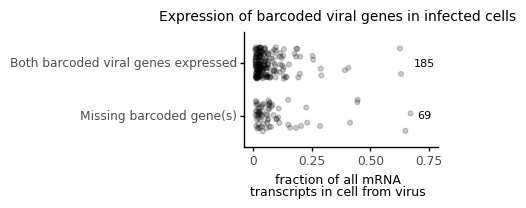

<ggplot: (8789011668465)>

In [53]:
barcoded_cells_file = figure_dir+'/'+'barcoded_cells_plot.svg'

barcoded_cells_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='all_barcoded_genes',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.2, height=0, width=0.3) +
    p9.geom_text(data=wt_infected_cells.groupby('all_barcoded_genes').nunique().reset_index(),
                 mapping=p9.aes(y=0.73,
                                label='cell_barcode'),
                 size=8) +
    p9.ggtitle(f'Expression of barcoded viral genes in infected cells') +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction of all mRNA\ntranscripts in cell from virus') +
    p9.scale_y_continuous(limits=[0,0.75], breaks=[0,0.25,0.5,0.75]) +
    p9.scale_x_discrete(labels=['Missing barcoded gene(s)', 'Both barcoded viral genes expressed']) +
    p9.theme(figure_size=(2.5, 1.5),
             plot_title=p9.element_text(size=10),
             axis_title=p9.element_text(size=9)))

barcoded_cells_plot.save(filename = barcoded_cells_file)
display(barcoded_cells_plot)

In [54]:
# Placeholder. Composite figure of pacbio coverage and barcoded gene expression.

In [55]:
# Placeholder. Venn diagram of cells with barcoded gene expression, pacbio coverage, or both.

### Select subset of cells with complete PacBio sequencing and both barcoded viral genes

In [56]:
display(wt_infected_cells
        .groupby("sequenced_and_barcoded")
        .aggregate(n_cells=pd.NamedAgg("cell_barcode", "count"))
)

sequenced_barcoded_cells = wt_infected_cells.query("sequenced_and_barcoded")
display(sequenced_barcoded_cells)

,n_cells
sequenced_and_barcoded,
False,162
True,92


,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,CTCGTTTTCGGAGTAC; GACTATCTAATTGAGG,0.00353158,0.000134919,0.000164641,2e-05,False,PA,True,True,True
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,TTTACTTTAAGTGCTT,1e-05,1e-05,1e-05,1e-05,True,,True,True,True
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,AGTTATTGGTTGGATA,2e-05,0.000971284,2e-05,2.17873e-05,True,,True,True,True
11,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,48,...,CTGTTGTTCTTTACCA,1e-05,7.18982e-05,0.000202201,0.000165321,True,,True,True,True
14,AATCGTGGTACTGAGG,infected,wt,168506,6655,0.039494,7,1417,2295,46,...,CGGTAAACGAACTTCA,1e-05,1e-05,1e-05,1e-05,False,NS,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,82,...,GTATTTGCAAAAAATG,0.000129506,0.000903955,1e-05,1.37795e-05,True,,True,True,True
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,GAGCTCCTGTATTGCC,1e-05,1e-05,1e-05,1e-05,False,PA,True,True,True
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,TAAAAAATGTCTCATG,0.00101405,0.00128394,0.000153675,1.54824e-05,True,,True,True,True
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,GGTATCAGTTATTGTT,1e-05,1e-05,1e-05,1e-05,False,NS; PB1,True,True,True


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2.5 x 1.5 in image.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/figures/sequenced_and_barcoded_plot.svg


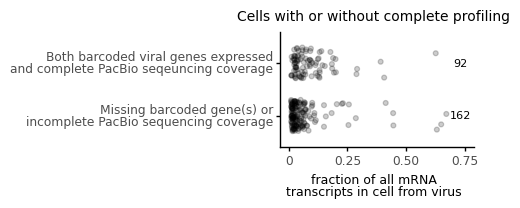

<ggplot: (8789012366680)>

In [57]:
sequenced_and_barcoded_file = figure_dir+'/'+'sequenced_and_barcoded_plot.svg'

sequenced_and_barcoded_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='sequenced_and_barcoded',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.2, height=0, width=0.3) +
    p9.geom_text(data=wt_infected_cells.groupby('sequenced_and_barcoded').nunique().reset_index(),
                 mapping=p9.aes(y=0.73,
                                label='cell_barcode'),
                 size=8) +
    p9.ggtitle(f'Cells with or without complete profiling') +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction of all mRNA\ntranscripts in cell from virus') +
    p9.scale_y_continuous(limits=[0,0.75], breaks=[0,0.25,0.5,0.75]) +
    p9.scale_x_discrete(labels=['Missing barcoded gene(s) or\nincomplete PacBio sequencing coverage', 'Both barcoded viral genes expressed\nand complete PacBio seqeuncing coverage']) +
    p9.theme(figure_size=(2.5, 1.5),
             plot_title=p9.element_text(size=10),
             axis_title=p9.element_text(size=9)))

sequenced_and_barcoded_plot.save(filename = sequenced_and_barcoded_file)
display(sequenced_and_barcoded_plot)

### Calculate progeny contribution
Normalize the the progeny viral barcode frequences among source and gene (e.g. 'supernatant fluHA'). Take the geometric mean of both barcoded genes to estimate the progeny contribution for each infected cell:

In [58]:
for condition in ["supernatant", "second_infection"]:
    for gene in barcoded_genes:
        # normalize among selected cells and within barcoded gene
        col = f"freq_{condition}_{gene}"
        sequenced_barcoded_cells[col] = (
            sequenced_barcoded_cells[col] /
            sequenced_barcoded_cells[col].sum()
        )
    # calculate geometric mean of normalized values
    mean_col = f"freq_{condition}"
    sequenced_barcoded_cells[mean_col] = (
        sequenced_barcoded_cells[f"{mean_col}_fluHA"]
        * sequenced_barcoded_cells[f"{mean_col}_fluNA"]
    )**(1 / 2)
    sequenced_barcoded_cells[mean_col] = (
        sequenced_barcoded_cells[mean_col] /
        sequenced_barcoded_cells[mean_col].sum()
    )

display(sequenced_barcoded_cells)

<ipython-input-58-64b21040e9dd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-58-64b21040e9dd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-58-64b21040e9dd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded,freq_supernatant,freq_second_infection
3,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,0.00124273,0.00332608,0.00013127,False,PA,True,True,True,0.0124222,0.00121747
4,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,9.21087e-05,0.00020202,6.5635e-05,True,,True,True,True,0.00017996,0.000212166
5,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,0.00894637,0.000404041,0.000143001,True,,True,True,True,0.00250821,0.000442886
11,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,48,...,0.000662245,0.00408488,0.00108509,True,,True,True,True,0.000482542,0.00387911
14,AATCGTGGTACTGAGG,infected,wt,168506,6655,0.039494,7,1417,2295,46,...,9.21087e-05,0.00020202,6.5635e-05,False,NS,True,True,True,0.00017996,0.000212166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,82,...,0.00832621,0.00020202,9.04417e-05,True,,True,True,True,0.00615736,0.000249053
404,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,9.21087e-05,0.00020202,6.5635e-05,False,PA,True,True,True,0.00017996,0.000212166
405,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,0.0118262,0.00310455,0.000101619,True,,True,True,True,0.0205343,0.0010349
408,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,9.21087e-05,0.00020202,6.5635e-05,False,NS; PB1,True,True,True,0.00017996,0.000212166


In [59]:
# Placeholder. Correlation betweeen physical progeny virions (supernatant) and infectious progeny virions (second_infection).

### Plot full viral genomes of infected cells with complete PacBio coverage
Needed to provide progeny contribution measurements where possible. Cells with complete PacBio data without progeny contribution measurements will have null value.

In [60]:
# Bring in progeny production measurements when available
fully_sequenced_cells_CSV = 'results/pacbio/fully_sequenced_cells.csv'

fully_sequenced_cells = pd.merge(
    left=fully_sequenced_cells,
    right=sequenced_barcoded_cells[['cell_barcode', 'freq_supernatant', 'freq_second_infection']],
    on='cell_barcode',
    how='left',
    validate='one_to_one'
)
display(fully_sequenced_cells)
print(f"Writing fully sequenced cells data to CSV: {fully_sequenced_cells_CSV}")
fully_sequenced_cells.to_csv(fully_sequenced_cells_CSV)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,sequenced_and_barcoded,viral_mutations,nonsynonymous_mutations,mutation_support,mutated_genes,has_mutations,has_nonsynonymous_mutations,nonsynonymous_mutation_count,freq_supernatant,freq_second_infection
0,AAAGGGCTCCGCACTT,infected,wt,128527,3021,0.023505,7,86,735,23,...,True,PB2: del168to2007 del2097to2106,"PB2: del168to2007, PB2: del2097to2106",PB2: 1597/1611 1601/1611,PB2,True,True,2,0.0124222,0.00121747
1,AAAGTCCAGTAGAGTT,infected,wt,75830,15135,0.199591,8,566,7232,82,...,True,,,,,False,False,0,0.00017996,0.000212166
2,AACCAACAGGGTCTTT,infected,wt,130332,17157,0.131641,8,1347,6280,4204,...,True,"M: A111C_synonymous, NA: del39to1256, NS: G550...","NA: del39to1256, NS: G550A_G184R, PA: A937C_T313P","M: 436/472, NA: 1483/1550, NS: 48/50, PA: 7/9","M, NA, NS, PA",True,True,3,0.00250821,0.000442886
3,AAGGAATAGATTGAGT,infected,wt,51455,1667,0.032397,6,3,435,99,...,False,,,,,False,False,0,NaN,NaN
4,AAGGAATAGCATCGAG,infected,wt,91039,3192,0.035062,8,114,1262,48,...,True,"NA: del43to43, PB2: T650A_F217Y","NA: del43to43, PB2: T650A_F217Y","NA: 14/14, PB2: 4/4","NA, PB2",True,True,2,0.000482542,0.00387911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,TTGAGTGTCCTGGGTG,infected,wt,43013,8648,0.201055,8,795,2317,82,...,True,,,,,False,False,0,0.00615736,0.000249053
119,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,30,...,True,HA: A954G_synonymous,,HA: 15/16,HA,True,False,0,0.00017996,0.000212166
120,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,71,...,True,,,,,False,False,0,0.0205343,0.0010349
121,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,219,...,True,HA: T465A_H155Q,HA: T465A_H155Q,HA: 85/90,HA,True,True,1,0.00017996,0.000212166


Writing fully sequenced cells data to CSV: results/pacbio/fully_sequenced_cells.csv
